In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [76]:
ds=pd.read_csv("training_set_features.csv")
training_features = pd.DataFrame(ds)

ko=pd.read_csv("training_set_labels.csv")
training_labels= pd.DataFrame(ko)

yo=pd.read_csv("test_set_features.csv")
test_set_features= pd.DataFrame(yo)

In [77]:
training_new_features = pd.merge(training_features,training_labels,on="respondent_id")

In [57]:
X = training_new_features.drop(columns=['respondent_id', 'xyz_vaccine', 'seasonal_vaccine'])
y = training_new_features[['xyz_vaccine', 'seasonal_vaccine']]


In [58]:
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


In [60]:
from sklearn.preprocessing import OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [61]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)


In [81]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Model Selection
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(LogisticRegression(random_state=42)))])

# Train the model
model.fit(X_train, y_train)


C:\Users\NITHIISH\anaconda4\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\NITHIISH\anaconda4\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['xyz_concern', 'xyz_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_hom...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object'))])),
                ('classifier',
                 MultiOutputClassifier(estimator=LogisticRegression(random_state=42)))])

In [82]:
y_val_pred_proba = model.predict_proba(X_val)

# Extract the predicted probabilities
xyz_vaccine_proba_val = y_val_pred_proba[0][:, 1]
seasonal_vaccine_proba_val = y_val_pred_proba[1][:, 1]


In [83]:
roc_auc_xyz_val = roc_auc_score(y_val['xyz_vaccine'], xyz_vaccine_proba_val)
roc_auc_seasonal_val = roc_auc_score(y_val['seasonal_vaccine'], seasonal_vaccine_proba_val)

In [84]:
print(f'ROC AUC for xyz_vaccine: {roc_auc_xyz_val}')
print(f'ROC AUC for seasonal_vaccine: {roc_auc_seasonal_val}')

ROC AUC for xyz_vaccine: 0.8313680256158132
ROC AUC for seasonal_vaccine: 0.8560714246904496


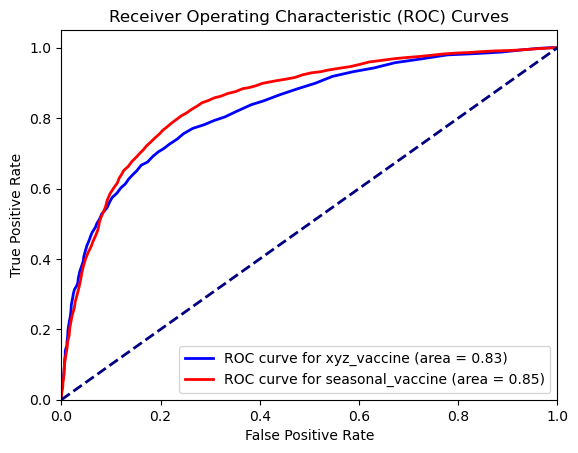

In [85]:
roc_auc_xyz = auc(fpr_xyz, tpr_xyz)
roc_auc_seasonal = auc(fpr_seasonal, tpr_seasonal)
plt.figure()
plt.plot(fpr_xyz, tpr_xyz, color='blue', lw=2, label=f'ROC curve for xyz_vaccine (area = {roc_auc_xyz:.2f})')
plt.plot(fpr_seasonal, tpr_seasonal, color='red', lw=2, label=f'ROC curve for seasonal_vaccine (area = {roc_auc_seasonal:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

In [86]:
test_pred_proba = model.predict_proba(test_set_features.drop(columns=['respondent_id']))
test_xyz_vaccine_proba = test_pred_proba[0][:, 1]
test_seasonal_vaccine_proba = test_pred_proba[1][:, 1]

In [87]:
submission = pd.DataFrame({
    'respondent_id': test_set_features['respondent_id'],
    'xyz_vaccine': test_xyz_vaccine_proba,
    'seasonal_vaccine': test_seasonal_vaccine_proba
})

In [89]:
submission.to_csv('submission.csv', index=False)